In [39]:
import sys
from pathlib import Path

exp_dir = str(Path("..").resolve())
if exp_dir not in sys.path:
    sys.path.insert(0, exp_dir)

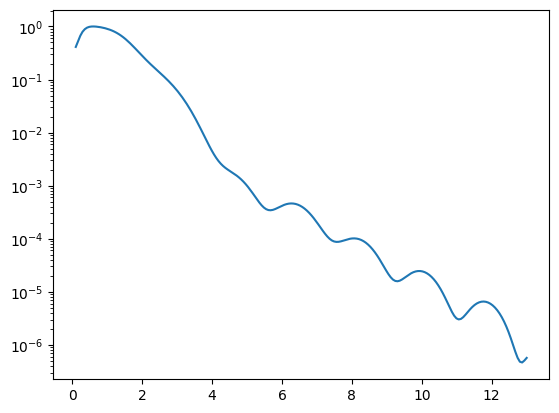

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from reflecto.physics_utils import tth2q
from reflecto.simulate.simul_genx import ParamSet, param2refl
from inference import XRRInferenceEngine
wavelen: float = 1.54
tth_min: float = 0.1   # degree
tth_max: float = 13
tth_n: int = 200
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q(tths, wavelen)

param = ParamSet(30, 1, 2)
sim_refl = param2refl(qs, [param])

refl = sim_refl
refl = refl / refl.max()
# refl = refl / refl[0]
plt.plot(tths, refl)
plt.yscale("log")

In [ ]:
engine = XRRInferenceEngine(exp_dir=r"D:\03_Resources\Data\XRR_AI\data\one_layer\mask")

# 2. 가상의 측정 데이터 (예시: qs와 true_refl이 있다고 가정)
# 실제 상황에서는 qs, true_refl = load_my_data()
print("\n--- Single Data Prediction ---")

# 테스트용 더미 데이터 생성 (사용자 데이터로 교체하세요)
test_q = qs
test_R = refl

# 3. 예측 실행
thickness_pred, roughness_pred, sld_pred = engine.predict(test_q, test_R)
param = ParamSet(thickness_pred, roughness_pred, sld_pred)

print("Predicted Parameters:")
print(f"  Thickness: {thickness_pred:.4f} Å")
print(f"  Roughness: {roughness_pred:.4f} Å")
print(f"  SLD:       {sld_pred:.4e} (10^-6 Å^-2)")

[Inference] Device: cuda
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\mask\best.pt

--- Single Data Prediction ---
Predicted Parameters:
  Thickness: 43.6901 Å
  Roughness: 1.2143 Å
  SLD:       9.6844e+00 (10^-6 Å^-2)


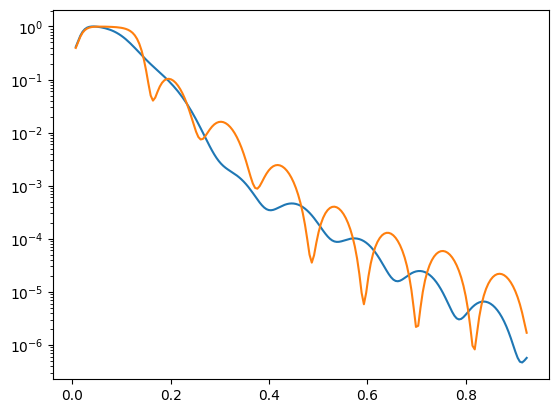

In [ ]:
param = ParamSet(thickness_pred, roughness_pred, sld_pred)
sim_refl = param2refl(test_q, [param])

plt.plot(test_q, refl)
plt.plot(test_q, sim_refl)
plt.yscale("log")

plt.show()

In [44]:
import numpy as np
from genx import fom_funcs
from genx.data import DataList, DataSet
from genx.model import Model
from genx.parameters import Parameters

# ---------------------------------------------------------
# 1) 데이터 준비
# ---------------------------------------------------------
qz = qs
R  = refl
dR = np.maximum(R * 0.1, 1e-9)

ds = DataSet(name="XRR 2-Layer Fit")
ds.x_raw = qz
ds.y_raw = R
ds.error_raw = dR
ds.run_command()

data = DataList([ds])

# 초기값 설정
val_film_thick = param.thickness
val_film_rough = param.roughness
val_film_sld   = param.sld * 1e6 if param.sld < 1.0 else param.sld

# SiO2 (자연 산화막) 초기값
val_sio_d   = 15.0
val_sio_sig = 3.0
val_sio_sld = 18.8 # 초기값

# ---------------------------------------------------------
# 2) GenX 스크립트
# ---------------------------------------------------------
script_text = rf"""
import numpy as np
from genx.models.spec_nx import Sample, Stack, Layer, Instrument, Specular
from genx.models.spec_nx import Probe, Coords, ResType, FootType
from genx.models.lib.physical_constants import r_e

# 초기값 상수 주입
init_f_d   = {val_film_thick}
init_f_sig = {val_film_rough}
init_f_sld = {val_film_sld}

init_s_d   = {val_sio_d}
init_s_sig = {val_sio_sig}
init_s_sld = {val_sio_sld}

class Vars:
    def __init__(self):
        self.f_d   = float(init_f_d)
        self.f_sig = float(init_f_sig)
        self.f_sld = float(init_f_sld)
        
        self.s_d   = float(init_s_d)
        self.s_sig = float(init_s_sig)
        self.s_sld = float(init_s_sld) 
        
        self.i0    = 1.0

    # --- Film Get/Set ---
    def set_film_d(self, v):   self.f_d = float(v)
    def get_film_d(self):      return self.f_d
    
    def set_film_sig(self, v): self.f_sig = float(v)
    def get_film_sig(self):    return self.f_sig
    
    def set_film_sld(self, v): self.f_sld = float(v)
    def get_film_sld(self):    return self.f_sld

    # --- SiO2 Get/Set ---
    def set_sio_d(self, v):    self.s_d = float(v)
    def get_sio_d(self):       return self.s_d
    
    def set_sio_sig(self, v):  self.s_sig = float(v)
    def get_sio_sig(self):     return self.s_sig

    # [추가됨] SiO2 SLD 피팅용 함수
    def set_sio_sld(self, v):  self.s_sld = float(v)
    def get_sio_sld(self):     return self.s_sld

    # --- Inst Get/Set ---
    def set_i0(self, v):       self.i0 = float(v)
    def get_i0(self):          return self.i0

vars = Vars()

def get_f(sld_1e6):
    return complex(sld_1e6 * 1e-6 / r_e, 0)

# --- Layer 구성 ---
Amb = Layer(d=0.0, f=0.0, dens=0.0)
Sub = Layer(d=0.0, f=get_f(20.07), dens=1.0, sigma=3.0) # Si 기판

# Material 1: Main Film
Film = Layer(d=vars.get_film_d(), 
             sigma=vars.get_film_sig(), 
             f=get_f(vars.get_film_sld()), 
             dens=1.0)

# Material 2: Surface SiO2
SiO2 = Layer(d=vars.get_sio_d(),
             sigma=vars.get_sio_sig(),
             f=get_f(vars.get_sio_sld()), # 변수 연결
             dens=1.0)

sample = Sample(Stacks=[Stack(Layers=[Film, SiO2])], Ambient=Amb, Substrate=Sub)

inst = Instrument(
    probe=Probe.xray, wavelength=1.54, coords=Coords.q,
    I0=vars.get_i0(), Ibkg=1e-10, res=0.002, 
    restype=ResType.fast_conv, footype=FootType.gauss
)

def _sync():
    # Film Update
    Film.d     = vars.get_film_d()
    Film.sigma = vars.get_film_sig()
    Film.f     = get_f(vars.get_film_sld())
    
    # SiO2 Update
    SiO2.d     = vars.get_sio_d()
    SiO2.sigma = vars.get_sio_sig()
    SiO2.f     = get_f(vars.get_sio_sld()) # [핵심] SLD 업데이트 추가
    
    inst.I0    = vars.get_i0()

def Sim(data):
    _sync()
    return [Specular(di.x, sample, inst) for di in data]
"""

model = Model()
model.data = data
model.set_script(script_text)
model.compile_script()

# ---------------------------------------------------------
# 3) 파라미터 등록
# ---------------------------------------------------------
pars = Parameters()

# [Material 1: Main Film]
p_f_d = pars.append("vars.set_film_d", model)
p_f_d.value = val_film_thick; p_f_d.min=10; p_f_d.max=1000

p_f_sig = pars.append("vars.set_film_sig", model)
p_f_sig.value = val_film_rough; p_f_sig.min=0; p_f_sig.max=30

p_f_sld = pars.append("vars.set_film_sld", model)
p_f_sld.value = val_film_sld; p_f_sld.min=10; p_f_sld.max=50

# [Material 2: Surface SiO2]
p_s_d = pars.append("vars.set_sio_d", model)
p_s_d.value = val_sio_d; p_s_d.min=5; p_s_d.max=50

p_s_sig = pars.append("vars.set_sio_sig", model)
p_s_sig.value = val_sio_sig; p_s_sig.min=0; p_s_sig.max=20

# [추가됨] SiO2 SLD 파라미터
p_s_sld = pars.append("vars.set_sio_sld", model)
p_s_sld.value = val_sio_sld; p_s_sld.min=15.0; p_s_sld.max=21.0 # SiO2는 보통 18~20 사이

# [Instrument: I0]
p_i0 = pars.append("vars.set_i0", model)
p_i0.value = 1.0; p_i0.min=0.1; p_i0.max=2.0

model.parameters = pars

# =========================================================
# [1차 피팅] 오로지 I0만 피팅 (나머지 FALSE)
# =========================================================
print("\n=== Step 1: Fitting ONLY I0 ===")

# 1. I0만 켜기
p_i0.fit = True

# 2. 나머지는 모두 끄기
p_f_d.fit = False; p_f_sig.fit = False; p_f_sld.fit = False
p_s_d.fit = False; p_s_sig.fit = False; p_s_sld.fit = False

# 3. Linear Scale & Nelder-Mead (단일 변수에 안전함)
model.set_fom_func(fom_funcs.diff)
res_1 = model.bumps_fit(method="de")
model.bumps_update_parameters(res_1)

print(f" -> Step 1 Result I0: {p_i0.value:.4f}")


# =========================================================
# [2차 피팅] 물질 2개 모든 파라미터 + I0 피팅
# =========================================================
print("\n=== Step 2: Fitting ALL Parameters (Film + SiO2 + I0) ===")

# 1. 모든 파라미터 켜기
p_i0.fit = False
p_f_d.fit = True; p_f_sig.fit = True; p_f_sld.fit = True
p_s_d.fit = False; p_s_sig.fit = False; p_s_sld.fit = False

# 2. Log Scale 사용
model.set_fom_func(fom_funcs.log)

# 3. Differential Evolution (DE) 실행
res_2 = model.bumps_fit(method="de", steps=600, pop=20, tol=0.005)
model.bumps_update_parameters(res_2)

# 4. 결과 확인
model.evaluate_sim_func()

print("\n--- Final Fitted Parameters ---")
print(f"I0             : {p_i0.value:.3f}")
print(f"Film Thickness : {p_f_d.value:.2f} Å")
print(f"Film Roughness : {p_f_sig.value:.2f} Å")
print(f"Film SLD       : {p_f_sld.value:.3f}")
print("-" * 30)
print(f"SiO2 Thickness : {p_s_d.value:.2f} Å")
print(f"SiO2 Roughness : {p_s_sig.value:.2f} Å")
print(f"SiO2 SLD       : {p_s_sld.value:.3f}") # 수정됨: SiO2 변수 출력


=== Step 1: Fitting ONLY I0 ===
 -> Step 1 Result I0: 1.1079

=== Step 2: Fitting ALL Parameters (Film + SiO2 + I0) ===


d:\02_Projects\Dev\X-ray_AI\Reflecto\.venv\Lib\site-packages\bumps\fitproblem.py:631: UserWarning: Unsatisfied constraints: [vars__film_sld=9.684388160705566 is outside (10.0,50.0)]
  warnings.warn("Unsatisfied constraints: [%s]" % (",\n".join(broken)))



--- Final Fitted Parameters ---
I0             : 1.108
Film Thickness : 922.63 Å
Film Roughness : 0.00 Å
Film SLD       : 50.000
------------------------------
SiO2 Thickness : 15.00 Å
SiO2 Roughness : 3.00 Å
SiO2 SLD       : 18.800


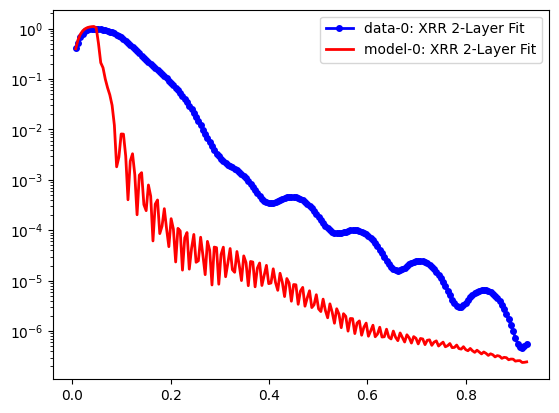

In [45]:
from genx.diffev import DiffEv
from genx.model_control import ModelController

controller = ModelController(DiffEv())
controller.set_model(model)
controller.StartFit()

fitted = controller.get_fitted_model()
fitted.simulate()
fitted.data.plot()
plt.show()